# How many SSO alerts can we expect per night of the LSST?

This notebook presents the results of querying the mid point exposure times for all Solar System Object (SSO) diaSources from DP0.3 which is hosted on the Rubin Science Platform (RSP). We use this to calculate the number of SSO alerts we expect LSST to generate per night and per visit.

These numbers should be compared to the predicted number of alerts for all transients detected by LSST, as presented in DMTN-102 (https://dmtn-102.lsst.io/)

In [1]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import rubin_sim.maf as maf

# Calculate number of visits per night

In [4]:
# select the survey simulation (DP0.3 was made using baseline_v3.0)
# Can be downloaded from: https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.0/baseline/
opsdb = "baseline_v3.0_10yrs.db"

In [5]:
# load the visit database
data = maf.get_sim_data(opsdb, None, None,
                      full_sql_query='select observationId,observationStartMJD from observations;')

# convert to dataframe
df = pd.DataFrame(data)

In [6]:
df.sort_values("observationStartMJD")

,observationId,observationStartMJD
0,0,60218.001806
1,1,60218.002260
2,2,60218.002715
3,3,60218.004914
4,4,60218.005362
...,...,...
2086074,2086074,63870.104316
2086075,2086075,63870.104764
2086076,2086076,63870.105213
2086077,2086077,63870.105661


In [7]:
int(np.amin(df["observationStartMJD"]))-0.5,int(np.amax(df["observationStartMJD"]))+1.5

(60217.5, 63871.5)

In [8]:
# create nightly bins and count the number of visits per night
visit_nights = np.arange(int(np.amin(df["observationStartMJD"]))-0.5,int(np.amax(df["observationStartMJD"]))+1.5,1)
visit_counts, visit_bins = np.histogram(df["observationStartMJD"], bins = visit_nights)
visit_centres = (visit_nights[:-1] + visit_nights[1:])/2.0

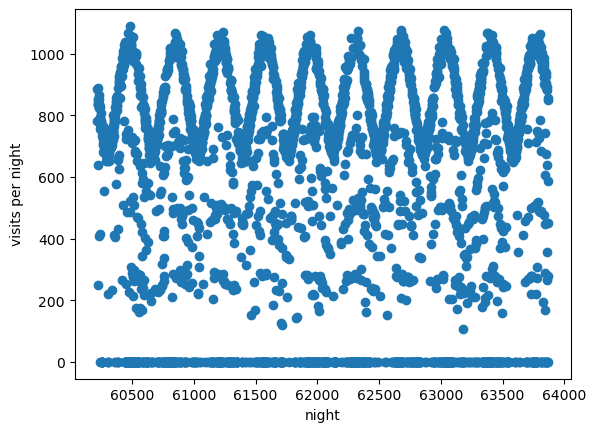

In [9]:
# plot of number of visits per night over the course of the 10yr survey
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])       

ax1.scatter(visit_centres,visit_counts)

ax1.set_xlabel("night")
ax1.set_ylabel("visits per night")

plt.show()

# load the counted number of SSO alerts per night

This was calculated by querying DP0.3 on the RSP using a query like:

```
dia = service.search("SELECT dia.midPointMjdTai "
                        "FROM dp03_catalogs_10yr.DiaSource AS dia "
                        "WHERE dia.midPointMjdTai>={} AND dia.midPointMjdTai<{}".format(int(t0)-0.5,int(t1)+0.5)).to_table()
```

We split this query into 28 day chunks (querying the full midPointMjdTai seemed to crash the RSP notebook!). The results of each query was binned by night and the counts and night bins were saved in the alert_counts folder.

In [10]:
# directory where the query results are saved
save_dir = "alert_counts"

# The queries where broken into 28 day chunks, using the following bins
mjd_min = np.amin(df["observationStartMJD"])
mjd_max = np.amax(df["observationStartMJD"])
mjd_nights = np.arange(int(mjd_min),int(mjd_max)+28,28)

# define empty lists to hold all results 
all_nights = []
all_counts = []

# loop to load all query result files in order
for i in range(len(mjd_nights[1:])):
    
    t0 = mjd_nights[i]
    t1 = mjd_nights[i+1]
    print(i,t0,t1)

    fname_count = "{}/counts_{}.npy".format(save_dir,i)
    fname_night = "{}/nights_{}.npy".format(save_dir,i)
    
    print("load: {} {}".format(fname_count,fname_night))
    counts = np.load(fname_count)
    nights = np.load(fname_night)
    
    # the righthand bins edges must be rejected to combine the separate chunks into one bin range spanning the full 10yrs
    all_nights+=list(nights[:-2])
    all_counts+=list(counts[:-1])
        
        
all_nights = np.append(np.array(all_nights),nights[-2]) # put the last righthand bin edge back
all_counts = np.array(all_counts)

# drop any nights over the survey duration 
# (we used 28 day query ranges and now need 1 night results)
mask = all_nights<=visit_nights[-1]
all_nights = all_nights[mask]
all_counts = all_counts[mask[1:]]

# calculate bin centres
all_centres = (all_nights[:-1] + all_nights[1:])/2.0

# determine the mean number of alerts per visit
# this is the mean per night as we calculate total alerts per night/total visits per night
alerts_visit = all_counts/visit_counts

0 60218 60246
load: alert_counts/counts_0.npy alert_counts/nights_0.npy
1 60246 60274
load: alert_counts/counts_1.npy alert_counts/nights_1.npy
2 60274 60302
load: alert_counts/counts_2.npy alert_counts/nights_2.npy
3 60302 60330
load: alert_counts/counts_3.npy alert_counts/nights_3.npy
4 60330 60358
load: alert_counts/counts_4.npy alert_counts/nights_4.npy
5 60358 60386
load: alert_counts/counts_5.npy alert_counts/nights_5.npy
6 60386 60414
load: alert_counts/counts_6.npy alert_counts/nights_6.npy
7 60414 60442
load: alert_counts/counts_7.npy alert_counts/nights_7.npy
8 60442 60470
load: alert_counts/counts_8.npy alert_counts/nights_8.npy
9 60470 60498
load: alert_counts/counts_9.npy alert_counts/nights_9.npy
10 60498 60526
load: alert_counts/counts_10.npy alert_counts/nights_10.npy
11 60526 60554
load: alert_counts/counts_11.npy alert_counts/nights_11.npy
12 60554 60582
load: alert_counts/counts_12.npy alert_counts/nights_12.npy
13 60582 60610
load: alert_counts/counts_13.npy alert_c

In [11]:
all_nights

array([60217.5, 60218.5, 60219.5, ..., 63868.5, 63869.5, 63870.5])

In [12]:
all_counts

array([  2634,    573, 102546, ..., 581016, 318229,   1916])

In [13]:
len(all_counts),len(all_nights)

(3653, 3654)

In [14]:
len(visit_counts),len(visit_nights)

(3653, 3654)

In [15]:
visit_nights

array([60217.5, 60218.5, 60219.5, ..., 63868.5, 63869.5, 63870.5])

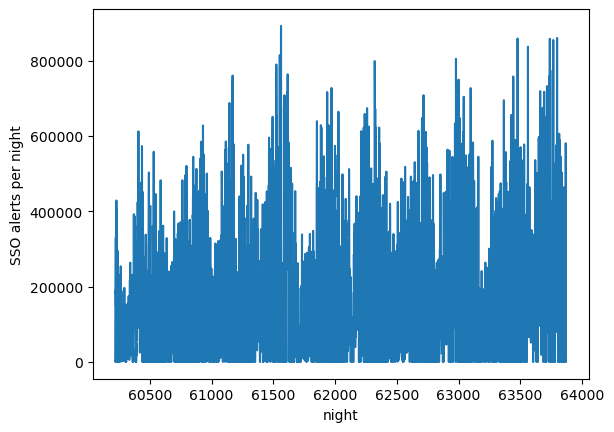

In [16]:
# plot of the total number of SSO alerts per night counted from DP0.3
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])       

ax1.plot(all_centres,all_counts)

ax1.set_xlabel("night")
ax1.set_ylabel("SSO alerts per night")

fname = "SSO_alerts_per_night.pdf"
plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

plt.show()

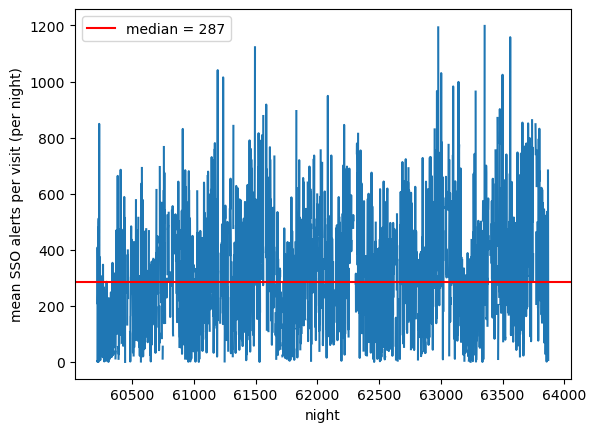

In [17]:
# plot of the mean number of SSO alerts per visit (per night)
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])       

ax1.plot(all_centres,alerts_visit)

x = np.nanmedian(alerts_visit)
ax1.axhline(x,c="r",label = "median = {:.0f}".format(x))

ax1.set_xlabel("night")
ax1.set_ylabel("mean SSO alerts per visit (per night)")
ax1.legend()

fname = "SSO_alerts_per_visit.pdf"
plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

plt.show()

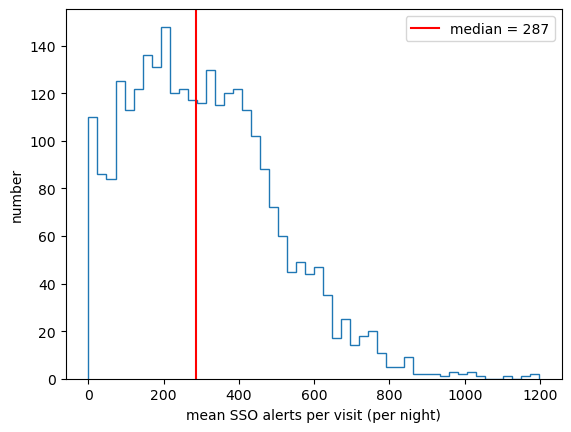

In [18]:
# histogram of the mean number of SSO alerts per visit per night
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])       

ax1.hist(alerts_visit,bins = 50, histtype = "step")

x = np.nanmedian(alerts_visit)
ax1.axvline(x,c="r",label = "median = {:.0f}".format(x))

ax1.set_ylabel("number")
ax1.set_xlabel("mean SSO alerts per visit (per night)")
ax1.legend()

fname = "SSO_alerts_per_visit_hist.pdf"
plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

plt.show()

From this analysis we can expect ~300 SSO alerts per visit for typical LSST visits. Note that this number is an order of magnitude lower than the predicted ~3000 SSO alerts per visit in DMTN-102. In section 2.2 of that document it has been assumed that all main belt asteroids are evenly spread across the sky and it would appear they have assumed they would all be visible. DP0.3 takes into account the distribution of small bodies across the sky and their brightness relative the the LSST detection limit. Therefore our value of ~300 alerts per visit is more accurate.

In comparison to the number of other transients alerts in DP0.3, SSO alerts are not expected to dominate the total number of alerts:
- Variable Stars: ~7200 alerts per visit
- Supernovae: ~200 alerts per visit
- Active Galactic Nuclei: ~70 alerts per visit
